In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)

Compared to prey_predator.ipynb, we increase the number of synthetic dataset (increase S from 1 to 2).

09:07:33 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/draws2data.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/draws2data
09:07:44 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/draws2data
09:07:44 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
09:07:44 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/draws2data.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/draws2data.stan', line 35, column 4: Declaration
    of arrays by pl

chain 1 |          | 00:00 Status

09:07:44 - cmdstanpy - INFO - CmdStan done processing.


09:07:46 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/data2draws.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/data2draws
09:07:56 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N200Q2R5/data2draws
09:07:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

09:29:28 - cmdstanpy - ERROR - CmdStan error: terminated by signal 2 Unknown error: -2


KeyboardInterrupt: 

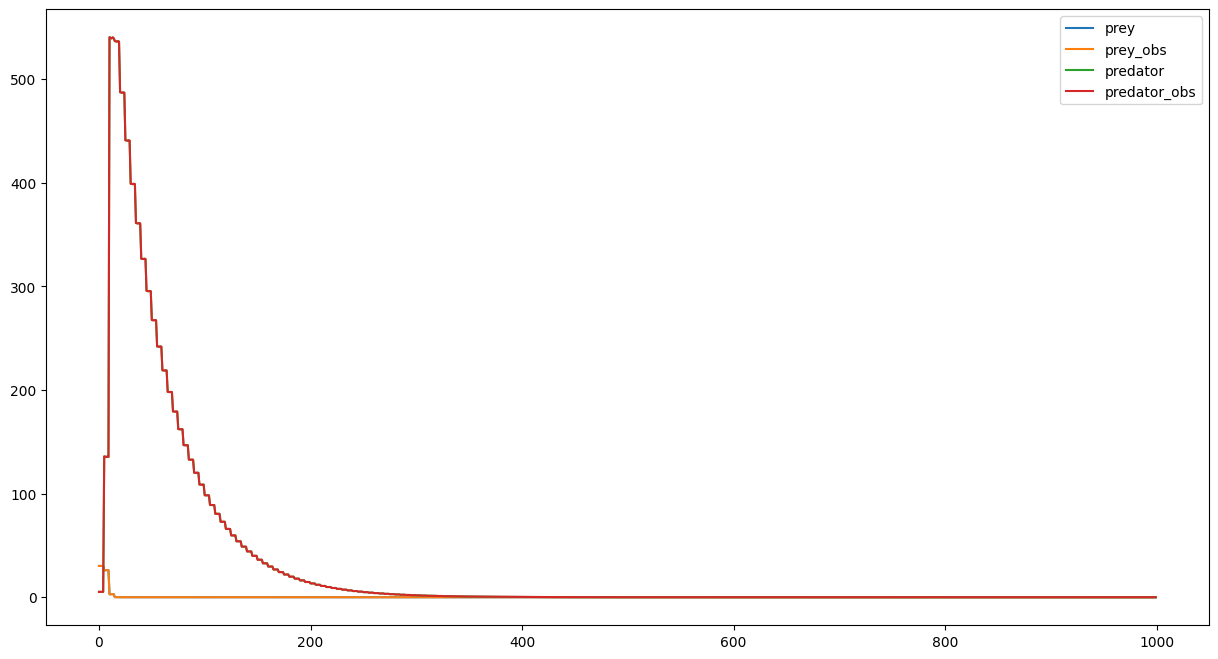

In [2]:
precision ={
    "S": 2, # # of draws from prior
    "M": 100, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 200, # # of observation
    "R": 1, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names": ("prey_birth_frac", "pred_birth_frac"),
    "hier_est_param_names" : ("pred_birth_frac"),
    "target_simulated_vector_names": ("prey", "predator"),
    "driving_vector_names": ("process_noise_uniform_driving"),
    "model_name": "prey_predator",
}

numeric = {
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size = precision['N']),
    'process_noise_scale': 0.05
}

prior = {
    ("prey_birth_frac", "normal", 0.8, 0.001, 0), # increase from .8
    ("pred_birth_frac", "normal", 0.5, 0.001, 0), # increase from .5
    ("m_noise_scale", "normal", .01, .001, 0)
}

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/prey_predator/prey_predator.mdl', setting, precision, numeric, prior, output_format)

In [ ]:
modelname = "prey_predator_S1N200Q2R5"
draws2data = az.from_netcdf(f"data/{modelname}/draws2data.nc")
data2draws = az.from_netcdf(f"data/{modelname}/data2draws.nc")

## diagnose numerically with InferenceData
`prior_draw` became 2, not 1.


In [ ]:
draws2data

Same with data2draws. Compared to adding hierarchy, increasing sensitivy runs doesn't affect the data structure (only the value of `prior_draw` changes).


In [ ]:
data2draws

In [ ]:
az.summary(data2draws)

## Diagnose visually with time series, trace, pair, rank plots
### time series of target simulated and its measurement noise added observed vector (TODO: plot this by region)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharey=True)

for target in ['prey', 'predator']:
    ax1.plot(draws2data.prior[target].mean('prior_draw').to_dataframe().values, label=f"{target}")
ax1.legend(loc= 'upper right')

for target in ['prey', 'predator']:
    ax2.plot(draws2data.prior_predictive[f'{target}_obs'].mean('prior_draw').to_dataframe().values, label=f"{target}_obs")
ax2.legend(loc= 'upper right')


### trace plot
shows estiamted prameters are not well-mixed between chains

In [ ]:
az.plot_trace(data2draws, figsize= (30, 20), var_names= ['pred_birth_frac', 'prey_birth_frac'], kind = "rank_bars")

### pair plot focused and all

In [ ]:
ax = az.plot_pair(data2draws,  var_names=['prey_birth_frac', 'pred_birth_frac'], divergences=True, textsize=22,)

In [ ]:
ax = az.plot_pair(data2draws,  divergences=True, textsize=22,) #, backend="bokeh" for interactive plot

### rank plot
indicates more than one peak

In [ ]:
fig, axes = plt.subplots(1, 2)
az.plot_rank(data2draws, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes)


# Appendix

## model

In [ ]:
print(CmdStanModel(stan_file=f"stan_files/{modelname}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{modelname}/data2draws.stan").code())

Compared to prey_predator.ipynb, we added hierarchy (increase R from 1 to 3). Users specify among which `est_param_names` becomes `hier_est_param_names`. Hierarchy in at least one parameter automatically adds subscripts to evey integrated outputs (integrated structure including, but not limited to `target_simulated_vector`).

In [ ]:
precision ={
    "S": 1, # # of draws from prior
    "M": 100, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 200, # # of observation
    "R": 3, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names": ("prey_birth_frac", "pred_birth_frac"),
    "hier_est_param_names" : ("pred_birth_frac"),
    "target_simulated_vector_names": ("prey", "predator"),
    "driving_vector_names": ("process_noise_uniform_driving"),
    "model_name": "prey_predator",
}

numeric = {
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size = precision['N']),
    'process_noise_scale': 0.01
}

prior = {
    ("prey_birth_frac", "normal", 0.8, 0.08, 0),
    ("pred_birth_frac", "normal", 0.05, 0.005, 0),
    ("m_noise_scale", "normal", .01, .001, 0)
}

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/prey_predator/prey_predator.mdl', setting, precision, numeric, prior, output_format)

In [ ]:
modelname = "prey_predator_S1N200Q2R3"
draws2data = az.from_netcdf(f"data/{modelname}/draws2data.nc")
data2draws = az.from_netcdf(f"data/{modelname}/data2draws.nc")

## diagnose numerically with InferenceData
Change before and after adding hierarchy can be seen from `Dimensions`, as hierarchical estimated parameter `pred_birth_frac` and  `prey`, `predator`, `porcess_noise` now have three dimension (=R from precision above).

In [ ]:
draws2data

Same with data2draws. Differences are also shown in index of `Data variables`. e.g. result of estimation for `prey_birth_frac` is (chain, draw) whereas `pred_birth_frac` has (chain, draw, pred_birth_frac_dim_0). Although `process_noise` is included, noise_scale is set to 0 during `data2draws()`, so we can ignore.


In [ ]:
data2draws

In [ ]:
az.summary(data2draws)

## Diagnose visually with time series, trace, pair, rank plots
### time series of target simulated and its measurement noise added observed vector (TODO: plot this by region)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharey=True)

for target in ['prey', 'predator']:
    ax1.plot(draws2data.prior[target].mean('prior_draw').to_dataframe().values, label=f"{target}")
ax1.legend(loc= 'upper right')

for target in ['prey', 'predator']:
    ax2.plot(draws2data.prior_predictive[f'{target}_obs'].mean('prior_draw').to_dataframe().values, label=f"{target}_obs")
ax2.legend(loc= 'upper right')


### trace plot
shows estiamted prameters are not well-mixed between chains

In [ ]:
az.plot_trace(data2draws, figsize= (30, 20), var_names= ['pred_birth_frac', 'prey_birth_frac'], kind = "rank_bars")

### pair plot focused and all

In [ ]:
ax = az.plot_pair(data2draws,  var_names=['prey_birth_frac', 'pred_birth_frac'], divergences=True, textsize=22,)

In [ ]:
ax = az.plot_pair(data2draws,  divergences=True, textsize=22,) #, backend="bokeh" for interactive plot

### rank plot
indicates more than one peak

In [ ]:
fig, axes = plt.subplots(1, 2)
az.plot_rank(data2draws, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes)


# Appendix

## model

In [ ]:
print(CmdStanModel(stan_file=f"stan_files/{modelname}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{modelname}/data2draws.stan").code())